<a href="https://colab.research.google.com/github/bchiramani/Personality_detection/blob/main/GPT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install emoji
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=4afe625413cf65549fe6ae5611e6776f11e2960017ec3f6076e6e927c720622b
  Stored in directory: /root/.cache/pip/wheels/9a/b8/0f/f580817231cbf59f6ade9fd132ff60ada1de9f7dc85521f857
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 22.8 MB/s eta 0:00:00


In [53]:
import pandas as pd
import numpy as np
import os
import csv
import tensorflow as tf

import emoji
import re, string
import nltk

import matplotlib.pyplot as plt
import seaborn as sns

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Read and Prepare Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/PFA/DATASET/trainset.csv',encoding='ISO-8859-1')
df_test = pd.read_csv('/content/drive/MyDrive/PFA/DATASET/testset.csv',encoding='ISO-8859-1')

In [ ]:

df=df[["user_name","Dates","Captions","I-E","S-N","T-F","J-P"]]
df_test=df_test[["user_name","Dates","Captions","I-E","S-N","T-F","J-P"]]

In [ ]:
df.head(3)

,user_name,Dates,Captions,I-E,S-N,T-F,J-P
0,barajas,"['2017-05-02 00:15:10', '2017-06-01 16:12:18',...","['Dog in sunset.\n', 'First of June\n', 'Anoth...",1.0,1.0,0.0,1.0
1,chricchio,"['2017-04-07 19:15:33', '2017-04-16 20:48:50',...","['Dark Brick Side\n', 'Genio nei cessi del cin...",0.0,0.0,0.0,0.0
2,lyndsmc,"['2017-04-30 17:35:34', '2017-07-05 01:21:48',...",['Stop and smell the firework flowers. #firewo...,0.0,0.0,0.0,0.0


In [ ]:
""" 
  All caption will concatinated in the user_caption field
"""
def caption_preparation(df):
  captions_list= []
  for user in df["Captions"]:
    user_caption =""
    for caption_index,caption in enumerate(eval(user)):
      user_caption += caption + "  ,  "
    captions_list.append(user_caption)
  df["user_caption"]= captions_list

In [ ]:
caption_preparation(df)
caption_preparation(df_test)

# Preprocessing

## Cleaning Functions 

In [ ]:
#Clean emojis from text
def strip_emoji(text):
  """
  Remove emojis from a string.
  """
  emoji_pattern = emoji_pattern = re.compile("["
                      u"\U0001F600-\U0001F64F"  # emoticons
                      u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                      u"\U0001F680-\U0001F6FF"  # transport & map symbols
                      u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                      u"\U00002702-\U000027B0"
                      u"\U000024C2-\U0001F251"
                      "]+", flags=re.UNICODE)
  return emoji_pattern.sub(r'', text)

In [ ]:
#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

In [ ]:
#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(caption):
    new_caption = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', caption)) #remove last hashtags
    new_caption2 = " ".join(word.strip() for word in re.split('#|_', new_caption)) #remove hashtags symbol from words in the middle of the sentence
    return new_caption2

In [ ]:
#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

In [ ]:
def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

## Apply Cleaning Functions  

In [ ]:
def clean(df):
  texts_new = []
  for caption in df["user_caption"]:
      texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(caption))))))
  df['text_clean'] = texts_new

In [ ]:
# For trainset
clean(df)
# For trainset
clean(df_test)

## Encoding 

In [ ]:
def encoding (df , att):
  df[att] = df[att].map({1.0:1,0.0:0})

In [ ]:
encoding(df,'I-E')
encoding(df_test,'I-E')

## Prepare Tokenizers

In [ ]:
MAX_LEN=128

In [ ]:
from transformers import TFGPT2Model, GPT2Tokenizer
# Define a custom tokenizer function and call the encode_plus method of the BERT tokenizer.
def tokenize_function(caption) :
  """
  "input_ids" contient les IDs des tokens pour chaque phrase encodée
  "attention_masks" contient des masques d'attention pour chaque phrase encodée.
  """
  tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
  tokenizer.add_special_tokens({'pad_token': '[PAD]'})
  tokens = tokenizer.encode_plus(
      caption,
      add_special_tokens=True,
      max_length=128,
      padding=True,
      truncation=True,
      return_attention_mask=True
  )
  return tokens['input_ids'], tokens['attention_mask']

In [ ]:
def tokenizing_df(df): 
  all_input_ids=[]
  all_attention_masks=[]
  for caption in df["text_clean"]:
    input_ids , attention_masks  = tokenize_function(caption)
    all_input_ids.append(input_ids)
    all_attention_masks.append(attention_masks)

  df['input_ids_gpt2'], df['attention_masks_gpt2'] = all_input_ids, all_attention_masks
  return df

In [ ]:
df=tokenizing_df(df)
df_test=tokenizing_df(df_test)

## Shuffle

In [ ]:
# Shuffle
df = df.sample(frac=1).reset_index(drop=True)
df_test=df.sample(frac=1).reset_index(drop=True)

In [ ]:
df.head(3)

,user_name,Dates,Captions,I-E,S-N,T-F,J-P,user_caption,text_clean,input_ids_gpt2,attention_masks_gpt2
0,hishamsaidak,"['2018-07-12 07:14:56', '2019-05-15 09:25:11',...",['Participating in RAPID SMQ2 Townhall & Raya ...,0,1.0,0.0,0.0,Participating in RAPID SMQ2 Townhall & Raya Ce...,participating in rapid smq2 townhall raya cele...,"[48013, 803, 287, 5801, 895, 80, 17, 3240, 183...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,luisgomezt,"['2017-04-10 02:06:08', '2017-04-10 20:04:21',...","['Sin palabras!!!\n', 'Eso sÃ­ que se contagia...",0,0.0,0.0,0.0,"Sin palabras!!!\n , Eso sÃ­ que se contagia!...",sin palabras eso s que se contagia wildlife el...,"[31369, 6340, 397, 8847, 1658, 78, 264, 8358, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,michaelguenther,"['2017-03-31 19:29:48', '2017-05-08 02:43:06',...","[""I recently tweeted about Papillons and then ...",0,0.0,0.0,0.0,I recently tweeted about Papillons and then th...,i recently tweeted about papillons and then th...,"[72, 2904, 10830, 546, 20461, 359, 684, 290, 7...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


## Train-validation split

In [ ]:
def spliting_data(df,ids,att_mask, att):
  data = df[[ids,att_mask,att]]
  train_data, valid_data = train_test_split(data, test_size=0.1, random_state=42)
  X_train= train_data[[ids,att_mask]]
  y_train = train_data[[att]]
  X_val= valid_data[[ids,att_mask]]
  y_val = valid_data[[att]]
  return X_train, X_val, y_train, y_val

In [ ]:
X_train, X_valid, y_train_ie, y_valid_ie = spliting_data(df,'input_ids_gpt2','attention_masks_gpt2', 'I-E')

In [ ]:
X_train, X_valid, y_train_sn, y_valid_sn = spliting_data(df,'input_ids_gpt2','attention_masks_gpt2', 'S-N')

In [ ]:
X_train, X_valid, y_train_tf, y_valid_tf = spliting_data(df,'input_ids_gpt2','attention_masks_gpt2', 'T-F')

In [ ]:
X_train, X_valid, y_train_jp, y_valid_jp = spliting_data(df,'input_ids_gpt2','attention_masks_gpt2', 'J-P')

In [ ]:
X_test = df_test[['input_ids_gpt2','attention_masks_gpt2']]
y_test_ie= df_test["I-E"]
y_test_sn= df_test["S-N"]
y_test_tf= df_test["T-F"]
y_test_jp= df_test["J-P"]

## One Hot Encoder

In [ ]:
y_train_hot_ie = y_train_ie.copy()
y_valid_hot_ie = y_valid_ie.copy()
y_test_hot_ie = y_test_ie.copy()

y_train_hot_sn = y_train_sn.copy()
y_valid_hot_sn = y_valid_sn.copy()
y_test_hot_sn = y_test_sn.copy()

y_train_hot_tf = y_train_tf.copy()
y_valid_hot_tf = y_valid_tf.copy()
y_test_hot_tf = y_test_tf.copy()

y_train_hot_jp = y_train_jp.copy()
y_valid_hot_jp = y_valid_jp.copy()
y_test_hot_jp = y_test_jp.copy()

In [ ]:
ohe = preprocessing.OneHotEncoder()
y_train_enc_ie = ohe.fit_transform(np.array(y_train_ie).reshape(-1, 1)).toarray()
y_valid_enc_ie = ohe.fit_transform(np.array(y_valid_ie).reshape(-1, 1)).toarray()
y_test_enc_ie = ohe.fit_transform(np.array(y_test_ie).reshape(-1, 1)).toarray()

y_train_enc_sn = ohe.fit_transform(np.array(y_train_sn).reshape(-1, 1)).toarray()
y_valid_enc_sn = ohe.fit_transform(np.array(y_valid_sn).reshape(-1, 1)).toarray()
y_test_enc_sn = ohe.fit_transform(np.array(y_test_sn).reshape(-1, 1)).toarray()

y_train_enc_tf = ohe.fit_transform(np.array(y_train_tf).reshape(-1, 1)).toarray()
y_valid_enc_tf = ohe.fit_transform(np.array(y_valid_tf).reshape(-1, 1)).toarray()
y_test_enc_tf = ohe.fit_transform(np.array(y_test_tf).reshape(-1, 1)).toarray()

y_train_enc_jp = ohe.fit_transform(np.array(y_train_jp).reshape(-1, 1)).toarray()
y_valid_enc_jp = ohe.fit_transform(np.array(y_valid_jp).reshape(-1, 1)).toarray()
y_test_enc_jp = ohe.fit_transform(np.array(y_test_jp).reshape(-1, 1)).toarray()

In [ ]:
train_input_ids_ragged = tf.ragged.constant(X_train['input_ids_gpt2'].tolist())
train_attention_mask_ragged = tf.ragged.constant(X_train['attention_masks_gpt2'].tolist())

val_input_ids_ragged = tf.ragged.constant(X_valid['input_ids_gpt2'].tolist())
val_attention_mask_ragged = tf.ragged.constant(X_valid['attention_masks_gpt2'].tolist())

test_input_ids_ragged = tf.ragged.constant(X_test['input_ids_gpt2'].tolist())
test_attention_mask_ragged = tf.ragged.constant(X_test['attention_masks_gpt2'].tolist())

In [ ]:
# convert the ragged tensors to dense tensors
train_input_ids = train_input_ids_ragged.to_tensor()
train_attention_mask = train_attention_mask_ragged.to_tensor()

val_input_ids = val_input_ids_ragged.to_tensor()
val_attention_mask = val_attention_mask_ragged.to_tensor()

test_input_ids = test_input_ids_ragged.to_tensor()
test_atention_mask = test_attention_mask_ragged.to_tensor()

# GPT2

# V1

In [ ]:
gpt2_model = TFGPT2Model.from_pretrained('gpt2', output_hidden_states=True)

All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [ ]:
MAX_LEN=128

In [ ]:
def create_model(gpt2_model, max_len=MAX_LEN): 
  #Define the input layers
  input_ids = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32)
  attention_mask = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32)

  # Pass the inputs through the GPT-2 model
  outputs = gpt2_model({'input_ids': input_ids, 'attention_mask': attention_mask})

  # Get the last hidden state output from the GPT-2 model
  last_hidden_state = outputs[0]

  # Add a dense layer for classification
  dense_layer = tf.keras.layers.Dense(1, activation='sigmoid')(last_hidden_state[:, -1, :])

  # Define the model
  model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=dense_layer)

  # Compile the model
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model 

In [ ]:
model = create_model(gpt2_model, MAX_LEN)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tfgpt2_model (TFGPT2Model)     TFBaseModelOutputWi  124439808   ['input_2[0][0]',                
                                thPastAndCrossAtten               'input_1[0][0]']                
                                tions(last_hidden_s                                               
                                tate=(None, 128, 76                                           

In [ ]:
 history_gpt2_ie = model.fit(
    [train_input_ids, train_attention_mask], y_train_ie, 

    validation_data=([val_input_ids, val_attention_mask], y_valid_ie),

    epochs=5, batch_size=32)

Epoch 1/5
5/5 [==============================] - 55s 3s/step - loss: 2.3012 - accuracy: 0.4667 - val_loss: 0.9389 - val_accuracy: 0.4667
Epoch 2/5
5/5 [==============================] - 4s 902ms/step - loss: 0.7568 - accuracy: 0.5185 - val_loss: 0.7353 - val_accuracy: 0.3333
Epoch 3/5
5/5 [==============================] - 5s 972ms/step - loss: 0.7079 - accuracy: 0.5185 - val_loss: 0.7209 - val_accuracy: 0.4667
Epoch 4/5
5/5 [==============================] - 7s 2s/step - loss: 0.6645 - accuracy: 0.5630 - val_loss: 0.7244 - val_accuracy: 0.4000
Epoch 5/5
5/5 [==============================] - 4s 786ms/step - loss: 0.6600 - accuracy: 0.5926 - val_loss: 0.7532 - val_accuracy: 0.4667


In [ ]:
y_pred_ie = model.predict([test_input_ids, test_atention_mask])
predictions_ie = np.round(y_pred_ie).astype(int)

In [52]:
print('\tClassification Report for GPT2 For I-E:\n\n',classification_report(y_test_ie,predictions_ie, target_names=['0', '1']))

	Classification Report for GPT2 For I-E:

               precision    recall  f1-score   support

           0       0.83      0.80      0.81        74
           1       0.81      0.84      0.83        76

    accuracy                           0.82       150
   macro avg       0.82      0.82      0.82       150
weighted avg       0.82      0.82      0.82       150



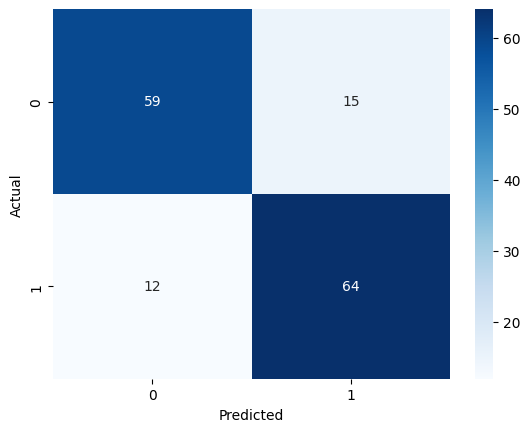

In [54]:
cm = confusion_matrix(y_test_ie, predictions_ie)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
history_gpt2_sn = model.fit(
    [train_input_ids, train_attention_mask], y_train_sn, 

    validation_data=([val_input_ids, val_attention_mask], y_valid_sn),

    epochs=5, batch_size=32)

Epoch 1/5
5/5 [==============================] - 18s 2s/step - loss: 0.7245 - accuracy: 0.5333 - val_loss: 0.7366 - val_accuracy: 0.2000
Epoch 2/5
5/5 [==============================] - 4s 754ms/step - loss: 0.7269 - accuracy: 0.5407 - val_loss: 0.5924 - val_accuracy: 0.7333
Epoch 3/5
5/5 [==============================] - 4s 757ms/step - loss: 0.6877 - accuracy: 0.5926 - val_loss: 0.6947 - val_accuracy: 0.5333
Epoch 4/5
5/5 [==============================] - 4s 800ms/step - loss: 0.6311 - accuracy: 0.6519 - val_loss: 0.6660 - val_accuracy: 0.4000
Epoch 5/5
5/5 [==============================] - 4s 769ms/step - loss: 0.6175 - accuracy: 0.6741 - val_loss: 0.7689 - val_accuracy: 0.0667


In [ ]:
y_pred_sn = model.predict([test_input_ids, test_atention_mask])
predictions_sn = np.round(y_pred_sn).astype(int)

5/5 [==============================] - 1s 295ms/step


In [ ]:
print('\tClassification Report for GPT2 FOR S-N :\n\n',classification_report(y_test_sn,predictions_sn, target_names=['0', '1']))

	Classification Report for GPT2 FOR S-N :

               precision    recall  f1-score   support

           0       0.79      0.54      0.64        63
           1       0.73      0.90      0.80        87

    accuracy                           0.75       150
   macro avg       0.76      0.72      0.72       150
weighted avg       0.75      0.75      0.74       150



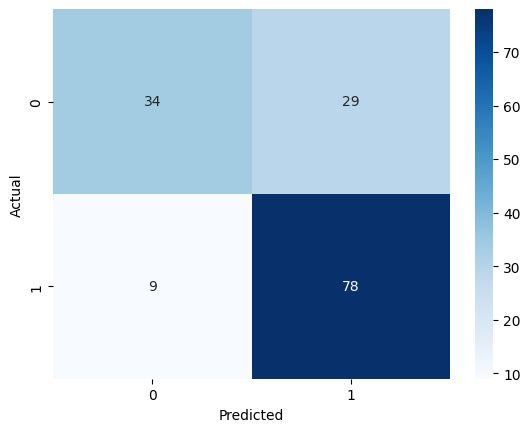

In [55]:
cm = confusion_matrix(y_test_sn, predictions_sn)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
history_gpt2_tf = model.fit(
    [train_input_ids, train_attention_mask], y_train_tf, 

    validation_data=([val_input_ids, val_attention_mask], y_valid_tf),

    epochs=5, batch_size=32)

Epoch 1/5
5/5 [==============================] - 5s 883ms/step - loss: 0.7557 - accuracy: 0.4667 - val_loss: 0.6868 - val_accuracy: 0.8000
Epoch 2/5
5/5 [==============================] - 5s 927ms/step - loss: 0.5274 - accuracy: 0.8593 - val_loss: 0.6927 - val_accuracy: 0.8000
Epoch 3/5
5/5 [==============================] - 8s 2s/step - loss: 0.3783 - accuracy: 0.8593 - val_loss: 0.5558 - val_accuracy: 0.8000
Epoch 4/5
5/5 [==============================] - 6s 1s/step - loss: 0.3144 - accuracy: 0.8593 - val_loss: 0.5821 - val_accuracy: 0.8000
Epoch 5/5
5/5 [==============================] - 7s 1s/step - loss: 0.2508 - accuracy: 0.8963 - val_loss: 0.6966 - val_accuracy: 0.8000


In [ ]:
y_pred_tf = model.predict([test_input_ids, test_atention_mask])
predictions_tf = np.round(y_pred_tf).astype(int)

5/5 [==============================] - 1s 309ms/step


In [ ]:
print('\tClassification Report for GPT2 FOR T-F :\n\n',classification_report(y_test_tf,predictions_tf, target_names=['0', '1']))

	Classification Report for GPT2 FOR T-F :

               precision    recall  f1-score   support

           0       0.92      1.00      0.96       128
           1       1.00      0.50      0.67        22

    accuracy                           0.93       150
   macro avg       0.96      0.75      0.81       150
weighted avg       0.93      0.93      0.92       150



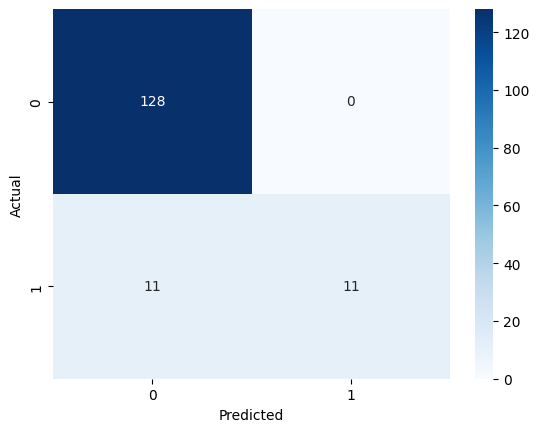

In [56]:
cm = confusion_matrix(y_test_tf, predictions_tf)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [49]:
history_gpt2_jp = model.fit(
    [train_input_ids, train_attention_mask], y_train_jp, 

    validation_data=([val_input_ids, val_attention_mask], y_valid_jp),

    epochs=5, batch_size=32)

Epoch 1/5
5/5 [==============================] - 5s 1s/step - loss: 1.1933 - accuracy: 0.5852 - val_loss: 0.7064 - val_accuracy: 0.5333
Epoch 2/5
5/5 [==============================] - 4s 817ms/step - loss: 0.6834 - accuracy: 0.5704 - val_loss: 0.6666 - val_accuracy: 0.6667
Epoch 3/5
5/5 [==============================] - 5s 912ms/step - loss: 0.6766 - accuracy: 0.5852 - val_loss: 0.6653 - val_accuracy: 0.6667
Epoch 4/5
5/5 [==============================] - 6s 1s/step - loss: 0.6239 - accuracy: 0.6370 - val_loss: 0.6428 - val_accuracy: 0.6667
Epoch 5/5
5/5 [==============================] - 6s 1s/step - loss: 0.6037 - accuracy: 0.6370 - val_loss: 0.6138 - val_accuracy: 0.6000


In [50]:
y_pred_jp = model.predict([test_input_ids, test_atention_mask])
predictions_jp = np.round(y_pred_jp).astype(int)

5/5 [==============================] - 1s 307ms/step


In [51]:
print('\tClassification Report for GPT2 FOR J-P :\n\n',classification_report(y_test_jp,predictions_jp, target_names=['0', '1']))

	Classification Report for GPT2 FOR J-P :

               precision    recall  f1-score   support

           0       0.81      0.79      0.80        96
           1       0.64      0.67      0.65        54

    accuracy                           0.75       150
   macro avg       0.73      0.73      0.73       150
weighted avg       0.75      0.75      0.75       150



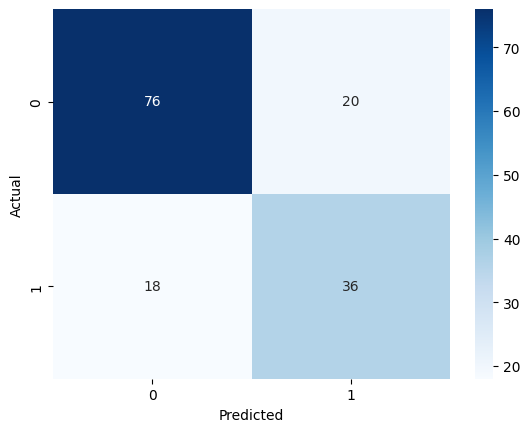

In [57]:
cm = confusion_matrix(y_test_jp, predictions_jp)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()